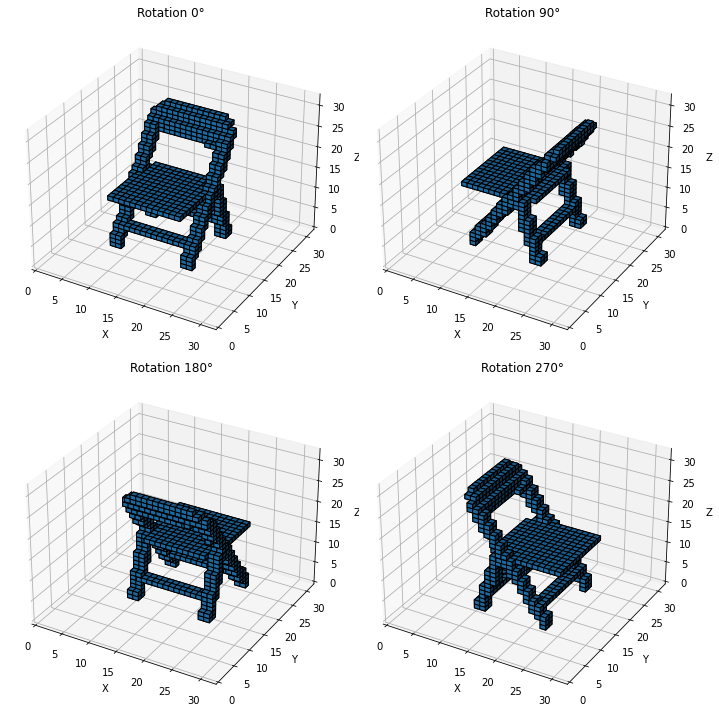

In [3]:
import torch
import matplotlib.pyplot as plt

# List of .pt files to load
dataset = "ModelNet10Voxel_32_28_1_4"
figures = [
    f"{dataset}/chair/train/chair_0001.pt", 
    f"{dataset}/chair/train/chair_0001rot90.pt", 
    f"{dataset}/chair/train/chair_0001rot180.pt",
    f"{dataset}/chair/train/chair_0001rot270.pt",
]

num_rows = 2
num_cols = 2
fig = plt.figure(figsize=(10, 10))  # Adjusted height for better visibility

for i, file_path in enumerate(figures):
    # Load the tensor from the .pt file
    sample = torch.load(file_path)
    
    # Move sample to CPU and convert to numpy array
    sample_np = sample.cpu().numpy().squeeze()  # Remove batch dimension if present

    # Create a 3D subplot
    ax = fig.add_subplot(num_rows, num_cols, i + 1, projection='3d')

    sample_np = (sample_np >= 0.5).astype(int)
    # Create voxel plot
    ax.voxels(sample_np, edgecolor='k')

    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.set_title(f"Rotation {i*90}°")

    ax.set_xlim(0, sample_np.shape[0])
    ax.set_ylim(0, sample_np.shape[1])
    ax.set_zlim(0, sample_np.shape[2])

plt.tight_layout()
plt.show()